In [3]:
import numpy as np

def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * (reg * Ui - Yij * Vj + Ui.dot(Vj) * Vj)

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * (reg * Vj - Yij * Ui + Ui.dot(Vj) * Ui)

def grad_bias(Vj, Yij, Ui, eta, ai, bj):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate), and bias entries ai, bj.

    Returns the gradient of the regularized loss function with
    respect to bias multiplied by learning rate.
    """
    return -eta * (Yij - (Ui.dot(Vj) + ai + bj))

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    sum_u = np.linalg.norm(U, ord = 'fro') ** 2
    sum_v = np.linalg.norm(V, ord = 'fro') ** 2
    sum_err = 0
    for i, j, rating in Y:
        i -= 1
        j -= 1
        sum_err += (rating - U[i, :].T.dot(V[j, :])) ** 2
    return reg / 2 * (sum_u + sum_v) + sum_err / 2

def get_err_bias(U, V, Y, a, b, reg = 0.0):
    sum_u = np.linalg.norm(U, ord = 'fro') ** 2
    sum_v = np.linalg.norm(V, ord = 'fro') ** 2
    sum_err = 0
    for i, j, rating in Y:
        i -= 1
        j -= 1
        if i >= U.shape[0] or j >= V.shape[0]:
            continue
        sum_err += (rating - U[i, :].T.dot(V[j, :]) - a[i] - b[j]) ** 2
    return reg / 2 * (sum_u + sum_v) + sum_err / 2

def get_err_shelf(shelf, U, V, Y):
    err = 0
    sum_u = np.linalg.norm(U, ord = 'fro') ** 2
    sum_v = np.linalg.norm(V, ord = 'fro') ** 2
    for i, j, rating in Y:
        err += (rating - shelf.predict(i, j, r_ui = rating).est) ** 2
    return reg / 2 * (sum_u + sum_v) + err / 2    

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300, bias = False):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    U = np.random.uniform(-0.5, 0.5, size = (M, K))
    V = np.random.uniform(-0.5, 0.5, size = (N, K))
    if bias:
        a = np.random.uniform(-0.5, 0.5, size = (M, ))
        b = np.random.uniform(-0.5, 0.5, size = (N, ))
    first_reduction = 0
    for k in range(max_epochs):
        if bias:
            curr_err = get_err_bias(U, V, Y, a, b, reg)
        else:
            curr_err = get_err(U, V, Y, reg)
        for i, j, rating in np.random.permutation(Y):
            i -= 1
            j -= 1
            Ui = np.copy(U[i, :])
            Vj = np.copy(V[j, :])
            U[i, :] -= grad_U(Ui, rating, Vj, reg, eta)
            V[j, :] -= grad_V(Vj, rating, Ui, reg, eta)
            if bias:
                ai = a[i]
                bj = b[j]
                change = grad_bias(Vj, rating, Ui, eta, ai, bj)
                a[i] -= change
                b[j] -= change
        if bias:
            next_err = get_err_bias(U, V, Y, a, b, reg)
        else:
            next_err = get_err(U, V, Y, reg)
        if k == 0:
            first_reduction = curr_err - next_err
        else:
            if (curr_err - next_err) / first_reduction <= eps:
                break
    if bias:
        return (U, V, next_err, a, b)
    else:
        return (U, V, next_err)

In [4]:
Y_train = np.loadtxt('data/train.txt').astype(int)
Y_test = np.loadtxt('data/test.txt').astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

reg = 0.0
eta = 0.03 # learning rate

U1,V1, err = train_model(M, N, K, eta, reg, Y_train)
E_in_no_bias = err
E_out_no_bias = get_err(U1, V1, Y_test)

Factorizing with  943  users,  1682  movies.


In [5]:
print(E_in_no_bias)
print(E_out_no_bias)

17172.72834869486
6123.385820104736


In [6]:
U2, V2, err, a, b = train_model(M, N, K, eta, reg, Y_train, bias = True)
E_in_bias = err
E_out_bias = get_err_bias(U2, V2, Y_test, a, b)

In [7]:
print(E_in_bias)
print(E_out_bias)

19464.677484203727
6082.44176393519


In [9]:
from surprise import SVD, Reader, Dataset
import pandas as pd

shelf = SVD(n_factors = K, n_epochs = 300, lr_all = eta, reg_all = 0)
df = pd.DataFrame({'userID': Y_train[:, 0], 'movieID': Y_train[:, 1], 'rating': Y_train[:, 2]})
reader = Reader(rating_scale = (1, 5))
data = Dataset.load_from_df(df[['userID', 'movieID', 'rating']], reader)
trainset = data.build_full_trainset()
shelf.fit(trainset)
E_in_shelf = get_err_shelf(shelf, shelf.pu, shelf.qi, Y_train)
E_out_shelf = get_err_shelf(shelf, shelf.pu, shelf.qi, Y_test)
U3 = shelf.pu
V3 = shelf.qi

In [10]:
print(E_in_shelf)
print(E_out_shelf)

11540.779842587153
7430.76740474833


# 2D visualization

In [11]:
V1_ = np.copy(V1)
U1_ = np.copy(U1)
V2_ = np.copy(V2)
U2_ = np.copy(U2)
V3_ = np.copy(V3)
U3_ = np.copy(U3)

In [12]:
# #mean centering V
# means = V1_.mean(axis = 0)
# V1_ -= means

# #shift U by same amount
# U1_ -= means

In [13]:
# 1 is without bias, 2 is with bias, 3 is surprise
A1, Sig1, B1 = np.linalg.svd(V1_.T, full_matrices=False)
A2, Sig2, B2 = np.linalg.svd(V2_.T, full_matrices=False)
A3, Sig3, B3 = np.linalg.svd(V3_.T, full_matrices=False)

In [14]:
V1_proj = A1[:,:2].T.dot(V1_.T)
U1_proj = A1[:,:2].T.dot(U1_.T)
V2_proj = A2[:,:2].T.dot(V2_.T)
U2_proj = A2[:,:2].T.dot(U2_.T)
V3_proj = A3[:,:2].T.dot(V3_.T)
U3_proj = A3[:,:2].T.dot(U3_.T)

In [15]:
# #rescaling so that each row of U_proj and V_proj has unit variance
# from sklearn import preprocessing

# V_proj = preprocessing.scale(V_proj)
# U_proj = preprocessing.scale(U_proj)

#Doesn't work!!

In [16]:
import matplotlib.pyplot as plt
import random
import csv

with open("data/movies.txt", encoding="latin_1") as f:
    reader = csv.reader(f, delimiter="\t")
    
    # Put the contents in a matrix
    movies = np.array(list(reader))

In [17]:
import matplotlib.pyplot as plt
import random

mov_i = np.random.choice(range(0, 1682), 10)
names = movies[:,1][mov_i]
plt.figure(figsize=(9,9))
for idx, i in enumerate(mov_i):
    x = V_proj[0,:][i]
    y = V_proj[1,:][i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x, y, names[idx], fontsize=9)
plt.show()

NameError: name 'V_proj' is not defined

<Figure size 648x648 with 0 Axes>

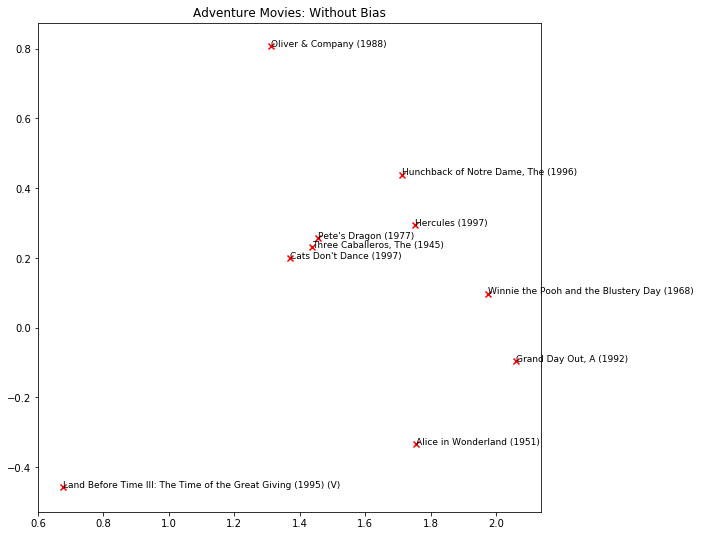

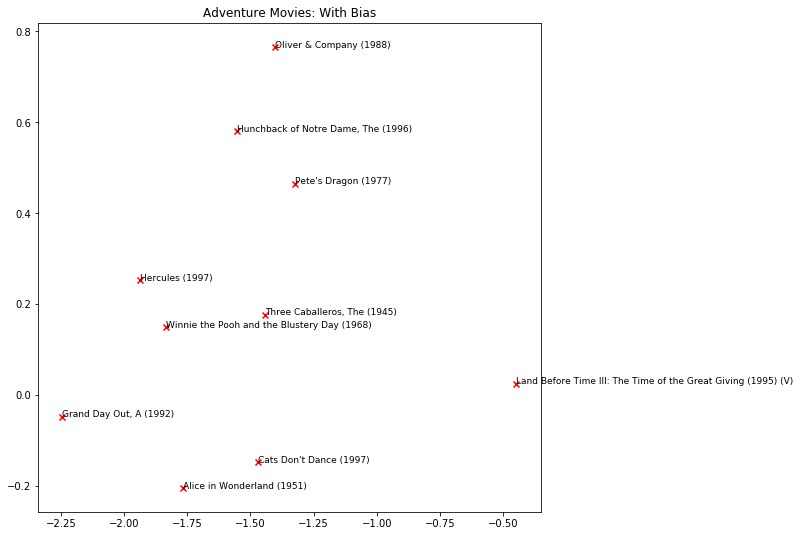

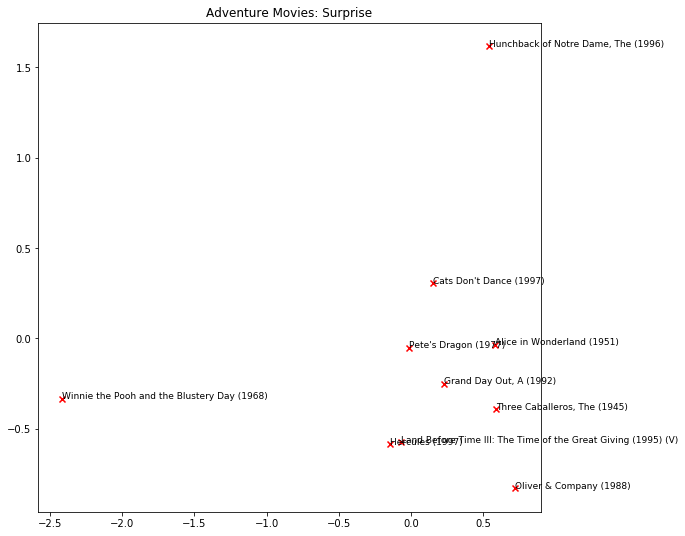

In [24]:
# Find Adventure Movies 5th column
IDs = []
for i, line in enumerate(movies):
    if int(line[5]):
        IDs.append(i)
mov_i = np.random.choice(IDs, 10)

names = movies[:,1][mov_i]

plt.figure(figsize=(9,9))
for idx, i in enumerate(mov_i):
    x = V1_proj[0,:][i]
    y = V1_proj[1,:][i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x, y, names[idx], fontsize=9)
plt.title('Adventure Movies: Without Bias')
plt.show()

plt.figure(figsize=(9,9))
for idx, i in enumerate(mov_i):
    x = V2_proj[0,:][i]
    y = V2_proj[1,:][i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x, y, names[idx], fontsize=9)
plt.title('Adventure Movies: With Bias')
plt.show()

plt.figure(figsize=(9,9))
for idx, i in enumerate(mov_i):
    x = V3_proj[0,:][i]
    y = V3_proj[1,:][i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x, y, names[idx], fontsize=9)
plt.title('Adventure Movies: Surprise')
plt.show()

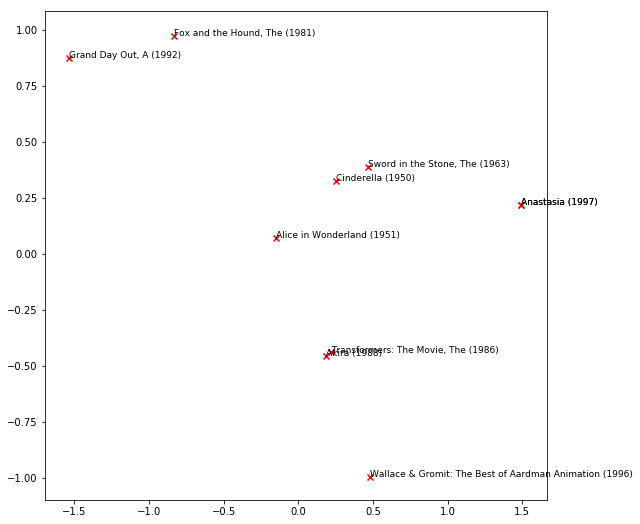

In [34]:
# Find Most popular movies
IDs = []
for i, line in enumerate(movies):
    if int(line[5]):
        IDs.append(i)
mov_i = np.random.choice(IDs, 10)


names = movies[:,1][mov_i]

plt.figure(figsize=(9,9))
for idx, i in enumerate(mov_i):
    x = V_proj[0,:][i]
    y = V_proj[1,:][i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x, y, names[idx], fontsize=9)
plt.show()

In [51]:
genres = np.array(['Unknown', 'Action', 'Adventure', 'Animation', 'Children’s', 'Comedy', 'Crime', 'Documentary',\
        'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
num = len(genres)
lst = []
for i, row in enumerate(movies):
    genre = genres[np.nonzero(list(map(int, movies[i][2:])))]
    print(i, row[1], genre)

0 Toy Story (1995) ['Animation' 'Children’s' 'Comedy']
1 GoldenEye (1995) ['Action' 'Adventure' 'Thriller']
2 Four Rooms (1995) ['Thriller']
3 Get Shorty (1995) ['Action' 'Comedy' 'Drama']
4 Copycat (1995) ['Crime' 'Drama' 'Thriller']
5 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995) ['Drama']
6 Twelve Monkeys (1995) ['Drama' 'Sci-Fi']
7 Babe (1995) ['Children’s' 'Comedy' 'Drama']
8 Dead Man Walking (1995) ['Drama']
9 Richard III (1995) ['Drama' 'War']
10 Seven (Se7en) (1995) ['Crime' 'Thriller']
11 Usual Suspects, The (1995) ['Crime' 'Thriller']
12 Mighty Aphrodite (1995) ['Comedy']
13 Postino, Il (1994) ['Drama' 'Romance']
14 Mr. Holland's Opus (1995) ['Drama']
15 French Twist (Gazon maudit) (1995) ['Comedy' 'Romance']
16 From Dusk Till Dawn (1996) ['Action' 'Comedy' 'Crime' 'Horror' 'Thriller']
17 White Balloon, The (1995) ['Drama']
18 Antonia's Line (1995) ['Drama']
19 Angels and Insects (1995) ['Drama' 'Romance']
20 Muppet Treasure Island (1996) ['Action' 'Adventure' 'Comedy'

501 Bananas (1971) ['Comedy' 'War']
502 Candidate, The (1972) ['Drama']
503 Bonnie and Clyde (1967) ['Crime' 'Drama']
504 Dial M for Murder (1954) ['Mystery' 'Thriller']
505 Rebel Without a Cause (1955) ['Drama']
506 Streetcar Named Desire, A (1951) ['Drama']
507 People vs. Larry Flynt, The (1996) ['Drama']
508 My Left Foot (1989) ['Drama']
509 Magnificent Seven, The (1954) ['Action' 'Drama' 'Western']
510 Lawrence of Arabia (1962) ['Adventure' 'War']
511 Wings of Desire (1987) ['Comedy' 'Drama' 'Romance']
512 Third Man, The (1949) ['Mystery' 'Thriller']
513 Annie Hall (1977) ['Comedy' 'Romance']
514 Boot, Das (1981) ['Action' 'Drama' 'War']
515 Local Hero (1983) ['Comedy']
516 Manhattan (1979) ['Comedy' 'Drama' 'Romance']
517 Miller's Crossing (1990) ['Drama']
518 Treasure of the Sierra Madre, The (1948) ['Adventure']
519 Great Escape, The (1963) ['Adventure' 'War']
520 Deer Hunter, The (1978) ['Drama' 'War']
521 Down by Law (1986) ['Comedy' 'Drama']
522 Cool Hand Luke (1967) ['Comedy

834 Gay Divorcee, The (1934) ['Comedy' 'Musical' 'Romance']
835 Ninotchka (1939) ['Comedy' 'Romance']
836 Meet John Doe (1941) ['Drama']
837 In the Line of Duty 2 (1987) ['Action']
838 Loch Ness (1995) ['Horror' 'Thriller']
839 Last Man Standing (1996) ['Action' 'Drama' 'Western']
840 Glimmer Man, The (1996) ['Action' 'Thriller']
841 Pollyanna (1960) ['Children’s' 'Comedy' 'Drama']
842 Shaggy Dog, The (1959) ['Children’s' 'Comedy']
843 Freeway (1996) ['Crime']
844 That Thing You Do! (1996) ['Comedy']
845 To Gillian on Her 37th Birthday (1996) ['Drama' 'Romance']
846 Looking for Richard (1996) ['Documentary' 'Drama']
847 Murder, My Sweet (1944) ['Film-Noir' 'Thriller']
848 Days of Thunder (1990) ['Action' 'Romance']
849 Perfect Candidate, A (1996) ['Documentary']
850 Two or Three Things I Know About Her (1966) ['Drama']
851 Bloody Child, The (1996) ['Drama' 'Thriller']
852 Braindead (1992) ['Comedy' 'Horror']
853 Bad Taste (1987) ['Comedy' 'Horror']
854 Diva (1981) ['Action' 'Drama' 'My

1278 Wild America (1997) ['Adventure' 'Children’s']
1279 Gang Related (1997) ['Crime']
1280 Manny & Lo (1996) ['Drama']
1281 Grass Harp, The (1995) ['Drama']
1282 Out to Sea (1997) ['Comedy']
1283 Before and After (1996) ['Drama' 'Mystery']
1284 Princess Caraboo (1994) ['Drama']
1285 Shall We Dance? (1937) ['Comedy' 'Musical' 'Romance']
1286 Ed (1996) ['Comedy']
1287 Denise Calls Up (1995) ['Comedy']
1288 Jack and Sarah (1995) ['Romance']
1289 Country Life (1994) ['Drama' 'Romance']
1290 Celtic Pride (1996) ['Comedy']
1291 Simple Wish, A (1997) ['Children’s' 'Fantasy']
1292 Star Kid (1997) ['Adventure' 'Children’s' 'Fantasy' 'Sci-Fi']
1293 Ayn Rand: A Sense of Life (1997) ['Documentary']
1294 Kicked in the Head (1997) ['Comedy' 'Drama']
1295 Indian Summer (1996) ['Comedy' 'Drama']
1296 Love Affair (1994) ['Drama' 'Romance']
1297 Band Wagon, The (1953) ['Comedy' 'Musical']
1298 Penny Serenade (1941) ['Drama' 'Romance']
1299 'Til There Was You (1997) ['Drama' 'Romance']
1300 Stripes (198

1667 Wedding Bell Blues (1996) ['Comedy']
1668 MURDER and murder (1996) ['Crime' 'Drama' 'Mystery']
1669 Tainted (1998) ['Comedy' 'Thriller']
1670 Further Gesture, A (1996) ['Drama']
1671 Kika (1993) ['Drama']
1672 Mirage (1995) ['Action' 'Thriller']
1673 Mamma Roma (1962) ['Drama']
1674 Sunchaser, The (1996) ['Drama']
1675 War at Home, The (1996) ['Drama']
1676 Sweet Nothing (1995) ['Drama']
1677 Mat' i syn (1997) ['Drama']
1678 B. Monkey (1998) ['Romance' 'Thriller']
1679 Sliding Doors (1998) ['Drama' 'Romance']
1680 You So Crazy (1994) ['Comedy']
1681 Scream of Stone (Schrei aus Stein) (1991) ['Drama']
